In [1]:
import tensorflow as tf
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from unet_models import simple_unet_model

2022-05-31 08:51:47.524917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 08:51:47.525135: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
image_directory = '/home/sudh4444/projects/onward_assignment/problem2/data/task_2/images/'
mask_directory = '/home/sudh4444/projects/onward_assignment/problem2/data/task_2/masks/'

In [3]:
SIZE = 256
image_list = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_list = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory)
for image_name in images:
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_list.append(np.array(image))

masks = os.listdir(mask_directory)
for image_name in masks:
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_list.append(np.array(image))

In [4]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_list), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_list)),3) / 255.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

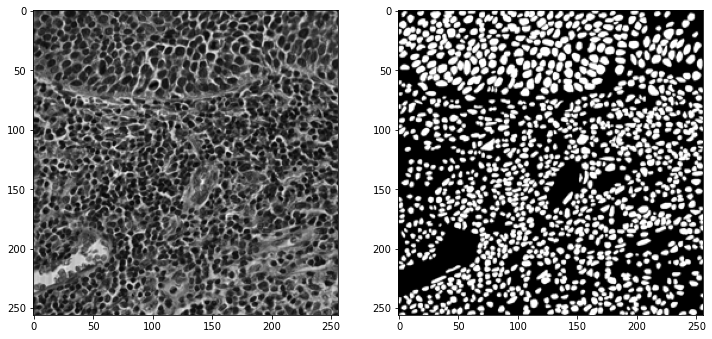

In [6]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [7]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [8]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()
model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-05-31 08:52:24.581751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-31 08:52:24.585536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sudh4444/projects/onward_assignment/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-31 08:52:24.586279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sudh4444/projects/onward_assignment/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-31 08:52:24.586537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could n

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/home/sudh4444/projects/onward_assignment/venv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 512)  2359808     ['conv2d_6[0][0]']               
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 512)  0          ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 1024  4719616     ['max_pooling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['conv2d_8[0][0]']               
                                )                                                                 
          

In [9]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)

batch_size= 8

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

In [11]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

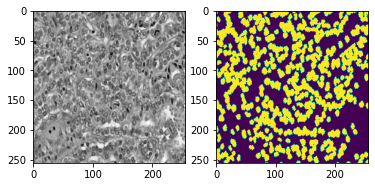

In [12]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


steps_per_epoch = 3*(len(X_train))//batch_size

In [14]:
history = model.fit(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=25)

Epoch 1/25
10/10 [==============================] - 19s 905ms/step - loss: 0.7987 - accuracy: 0.5119 - val_loss: 0.7092 - val_accuracy: 0.3451
Epoch 2/25
10/10 [==============================] - 4s 443ms/step - loss: 0.6945 - accuracy: 0.5011 - val_loss: 0.6986 - val_accuracy: 0.3907
Epoch 3/25
10/10 [==============================] - 4s 443ms/step - loss: 0.6912 - accuracy: 0.5434 - val_loss: 0.6894 - val_accuracy: 0.5851
Epoch 4/25
10/10 [==============================] - 4s 444ms/step - loss: 0.6900 - accuracy: 0.5594 - val_loss: 0.6829 - val_accuracy: 0.6234
Epoch 5/25
10/10 [==============================] - 4s 442ms/step - loss: 0.6885 - accuracy: 0.5331 - val_loss: 0.6885 - val_accuracy: 0.5339
Epoch 6/25
10/10 [==============================] - 4s 445ms/step - loss: 0.6846 - accuracy: 0.5614 - val_loss: 0.7001 - val_accuracy: 0.4820
Epoch 7/25
10/10 [==============================] - 4s 447ms/step - loss: 0.6835 - accuracy: 0.5646 - val_loss: 0.6968 - val_accuracy: 0.4950
Epoch

In [15]:
model.save('models/nuclei_test.hdf5')
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 1s 524ms/step - loss: 0.7039 - accuracy: 0.3651
Accuracy =  36.50716245174408 %


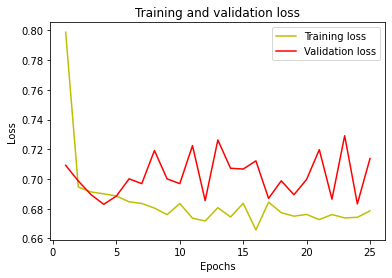

In [16]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

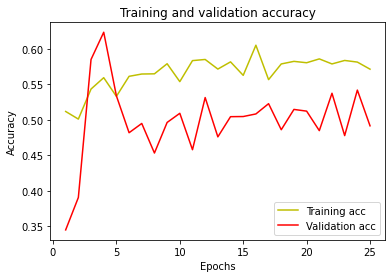

In [17]:
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.33028628759745554


1/1 [==============================] - 2s 2s/step


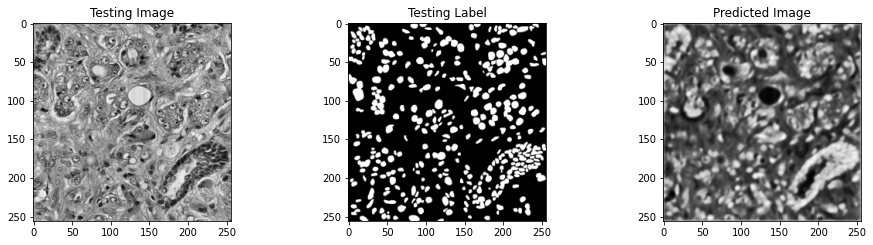

In [14]:
#Predict on a few images
model = get_model()
model.load_weights('models/nuclei_test.hdf5') #Trained for 50 epochs and then additional 100

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_train[test_img_number]
ground_truth=y_train[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_seg = (prediction[0,:,:,0]*255).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted Image')
plt.imshow(predicted_seg, cmap='gray')